## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [211]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [216]:
# Перевод признака даты к типу datetime
data.date = pd.to_datetime(data.date)
# группируем по группам и определяем минимальное и максимальное значения дат
test_start = data.groupby(by=['group'])['date'].min().dt.strftime('%d.%m.%y')
test_finish = data.groupby(by=['group'])['date'].max().dt.strftime('%d.%m.%y')
print(f'Дата начала исследований: \n\t- для группы A: {test_start[0]} \n\t- для группы B: {test_start[1]}')
print(f'Дата окончания исследований: \n\t- для группы A: {test_finish[0]} \n\t- для группы B: {test_finish[1]}')

Дата начала исследований: 
	- для группы A: 02.01.21 
	- для группы B: 02.01.21
Дата окончания исследований: 
	- для группы A: 24.01.21 
	- для группы B: 24.01.21


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [217]:
# определяем общее колличество посещений сайта
total_visits = data.groupby(by=['group'])['user_id'].count()
print(f'Количество посещений сайта: \n\t- в группе А: {total_visits[0]}\n\t- в группе B: {total_visits[1]}')

# определяем суммарное количество покупок по группам
total_purch = data.groupby(by=['group'])['purchase'].sum()
print(f'Суммарное количество покупок: \n\t- в группе А: {total_purch[0]}\n\t- в группе B: {total_purch[1]}')

# определяем сумму всех покупок по группам
sum_price = data.groupby(by=['group'])['price'].sum()
print(f'Сумма всех покупок: \n\t- в группе А: {round(sum_price[0]/(10**6), 2)} млн. руб.\n\t- в группе B: {round(sum_price[1]/(10**6), 2)} млн. руб.')


Количество посещений сайта: 
	- в группе А: 147202
	- в группе B: 147276
Суммарное количество покупок: 
	- в группе А: 17723
	- в группе B: 17514
Сумма всех покупок: 
	- в группе А: 1436.26 млн. руб.
	- в группе B: 1554.1 млн. руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [218]:
# определяем множество пользователей группы А и B
group_a_users = set(data[data['group'] == 'A']['user_id'].unique())
group_b_users = set(data[data['group'] == 'B']['user_id'].unique())
# количество пересекающихся пользователей
intersesct_users = group_a_users.intersection(group_b_users)
num_of_intersesct_users = len(intersesct_users)
print(f'Количество пользователей, которые в процессе A/B-теста попали в обе тестовые группы:\
      \n\t- {num_of_intersesct_users} человек')

Количество пользователей, которые в процессе A/B-теста попали в обе тестовые группы:      
	- 1895 человек


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

In [219]:
data = data[data['user_id'].apply(lambda x: x not in intersesct_users)]

Где intersesct_users - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

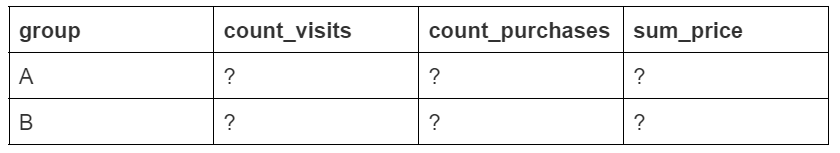
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [220]:
groupped_data = data.groupby(by=['group'], as_index=False)\
    .agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})\
    .rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
    
groupped_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


In [221]:
145307/(145307+145381)

0.4998727157639806

Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

#### Выводы
Считаю, что выборки сбалансированы, т.к. количество посещений в группе A практически равно количеству посещений в группе B (49.99/50.01).  

Но как это обосновать не знаю...

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [222]:
# добавляем признак конверсии
groupped_data['conversion'] = round(groupped_data['count_purchases'] / groupped_data['count_visits'] * 100, 2)
# добавляем признак среднего чека
groupped_data['mean_check'] = round(groupped_data['sum_price'] / groupped_data['count_purchases'])

groupped_data

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

#### Выводы
Вариант А эффективнее варианта B по показателю конверсии.
Вариант B эффективнее варианта А по показателю среднего чека.
Таким образом на данном этапе видно, что группа А покупает чаще, но более дешевые путевки.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [223]:
pivot_group_price = pd.pivot_table(data, values='purchase', index=['price'],
               columns=['group'], aggfunc=np.sum).drop(index=0)

pivot_group_price

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

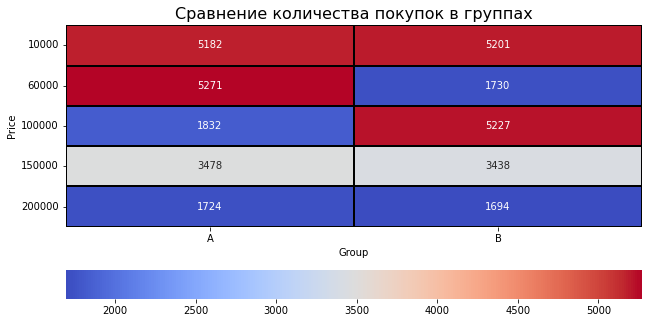

In [224]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])

# строим heatmap
sns.heatmap(data=pivot_group_price, ax=ax, annot=True,
            fmt='.4g', cmap= 'coolwarm', linewidths=1.5, linecolor='black',
            cbar_kws= {'orientation': 'horizontal'})
# задаём подпись к графику


ax.set_title('Сравнение количества покупок в группах', fontsize=16)
ax.set_xlabel('Group');
ax.set_ylabel('Price');
plt.yticks(rotation=0);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

#### Выводы
Покупательская способность группы А высока по турам за 10 и 60 тысяч. При этом туры за 60 тысяч значительно популярнее среди пользователей группы А. При этом в группе Б популярны туры за 10 тысяч (на уровне с группой А), но значительно популярнее относительно группы А туры за 100 тысяч. Средней популярностью в обоих группах пользуются туры за 150 тысяч, и на одинаково низком уровне туры за 200 тысяч.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [225]:
# группируем дф по группе и дате
date_group_groupped = data.groupby(by=['group', 'date'], as_index=False).\
    agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).\
    rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

# добавляем инф по ежедневной конверсии и среднему чеку
date_group_groupped['converce'] = round(date_group_groupped['count_purchases'] / date_group_groupped['count_visits'] * 100, 2)
date_group_groupped['mean_check'] = round(date_group_groupped['sum_price'] / date_group_groupped['count_purchases'])

date_group_groupped[date_group_groupped['date'] == '2021-01-03']

,group,date,count_visits,count_purchases,sum_price,converce,mean_check
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
24,B,2021-01-03,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [244]:
cum_data = date_group_groupped.copy()
# создаем новый признак кумулятивного количества посещений страницы 
cum_data['cum_users_count'] = cum_data.groupby(['group'])['count_visits'].cumsum()
cum_data['cum_purchases'] = cum_data.groupby(['group'])['count_purchases'].cumsum()
cum_data['cum_sum_price'] = cum_data.groupby(['group'])['sum_price'].cumsum()

# расчитываем кумулятивную конверсии и кум.ср.чек
cum_data['cum_converse'] = round(cum_data['cum_purchases'] / cum_data['cum_users_count'] * 100, 2)
cum_data['cum_mean_check'] = round(cum_data['cum_sum_price'] / cum_data['cum_purchases'])

cum_data[cum_data['date'] == '2021-01-12']


,group,date,count_visits,count_purchases,sum_price,converce,mean_check,cum_users_count,cum_purchases,cum_sum_price,cum_converse,cum_mean_check
10,A,2021-01-12,6540,795,68460000,12.16,86113.0,68852,8198,668070000,11.91,81492.0
33,B,2021-01-12,6635,807,70560000,12.16,87435.0,69251,8236,727670000,11.89,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

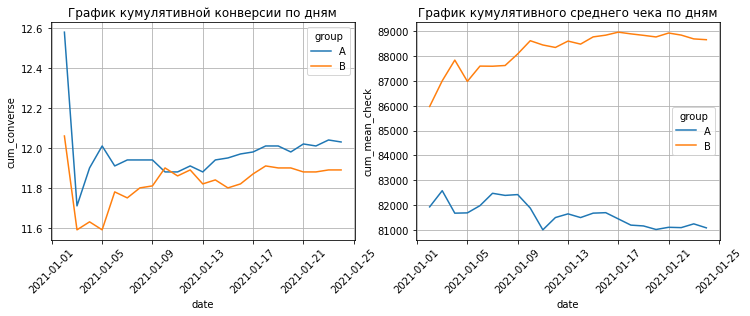

In [251]:
# создаём фигуру размером 8x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_converse', data=cum_data, hue='group', ax=axes[0])
# задаём подпись к графику
axes[0].set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
axes[0].xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
axes[0].grid(True);

# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=cum_data, hue='group', ax=axes[1])
# задаём подпись к графику
axes[1].set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
axes[1].xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
axes[1].grid(True);

#### Выводы
Я думаю, можно сказать, что графики постепенно стабилизировались. Видно, что кумулятивная конверсия примерно с 13 числа начала стабилизироваться и при этом конверсия в группе А начала быть стабильно выше чем в группе В.

При этом кумулятивный средний чек так же с 13го числа в группе А идёт на спад, а в группе В растет. Так же Кум.ср.чек в группе В на всём протяжении теста стабильно выше.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [283]:
from statsmodels.stats.proportion import proportions_ztest

# группируем данные
converted_piv= data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

#### Выводы
По результатам z-теста для пропорций установлено, что отсутствует статистическая разница между конверсиями в разных группа. Нулевая гипотеза принята, так как p-value больше уровня значимости

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [286]:
#фильтруем данные группы А
a_data = data[data['group'] == 'A']
#фильтруем данные группы B
b_data = data[data['group'] == 'B']

# объявляем функцию нахождения интервала
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# применяем функцию к данным
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

# функция для доверительного интервала разницы
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# вызываем функцию для выборок
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))



Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

#### Выводы
С надежностью 95% конверсия группы А лежит в интервале (11.87, 12.2)%, а конверсия группы B лежит в интервале (11.73, 12.06)%.  
Разница конверсий между двумя вариантами лежит в интервале (-0.38, 0.09). И так как интервал открывает точку 0 - это значит, что группы А и Б равнозначны по метрике конверсии.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [288]:
cum_data.head(3)

,group,date,count_visits,count_purchases,sum_price,converce,mean_check,cum_users_count,cum_purchases,cum_sum_price,cum_converse,cum_mean_check
0,A,2021-01-02,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.71,82575.0
2,A,2021-01-04,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.90,81668.0


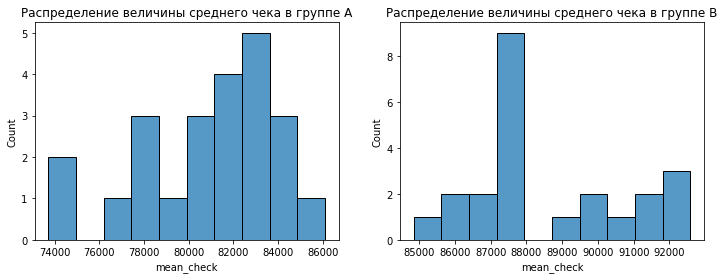

In [293]:
#  визуализируем распределение
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean_check', data=cum_data[cum_data['group'] == 'A'], ax=axes[0], bins=10)
sns.histplot(x='mean_check', data=cum_data[cum_data['group'] == 'B'], ax=axes[1], bins=10)
#задаём названия графикам
axes[0].set_title('Распределение величины среднего чека в группе А');
axes[1].set_title('Распределение величины среднего чека в группе B');

In [295]:
# для проверки гипотезы на нормальность применяем тест Шапиро-Уилка
# Подходит для выборок с тысячью наблюдей и меньше
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(cum_data[cum_data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(cum_data[cum_data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [296]:
# Применим T-тест для сравнения средних
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=cum_data[cum_data['group'] == 'A']['mean_check'],
    b=cum_data[cum_data['group'] == 'B']['mean_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

#### Выводы
По результату статистического Т-теста установеленно наличие статистической разницы и, что с вероятностью 95% ежедневный средний чек в группе А меньше чем в группе В.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [301]:
cum_data[cum_data['group'] == 'A'].head()

,group,date,count_visits,count_purchases,sum_price,converce,mean_check,cum_users_count,cum_purchases,cum_sum_price,cum_converse,cum_mean_check
0,A,2021-01-02,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.71,82575.0
2,A,2021-01-04,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.90,81668.0
3,A,2021-01-05,6433,790,64550000,12.28,81709.0,22449,2696,220210000,12.01,81680.0
4,A,2021-01-06,6606,764,63410000,11.57,82997.0,29055,3460,283620000,11.91,81971.0


In [303]:
# исходные данные для группы А
n = cum_data[cum_data['group'] == 'A'].shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean = cum_data[cum_data['group'] == 'A']['mean_check'].mean() # выборочное среднее
x_std = cum_data[cum_data['group'] == 'A']['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

# доверительный интервал для истинного среднего
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для группы А: {}'.format(confidence_interval)) # выводим результат


# исходные данные для группы B
n = cum_data[cum_data['group'] == 'B'].shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean = cum_data[cum_data['group'] == 'B']['mean_check'].mean() # выборочное среднее
x_std = cum_data[cum_data['group'] == 'B']['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

# доверительный интервал для истинного среднего
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для группы B: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал для группы А: (79630, 82308)
Доверительный интервал для группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Построенные доверительные интервалы говорят о том, что с вероятностью 95% пересечений по истиным средним ежедневным суммам нет и  таким образом истиное среднее для группы B как минимум на 5318 больше чем истиное среднее в группе A.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

#### Выводы
В результате проведенного анализа установлено, что нет статистически значимой разницы метрики конверсии в группах (по результату Z-теста и построению доверительного интервала). 
Установлено, что с 95% вероятностью средний чек группы А меньше среднего чека группы B (результаты Т-теста). Так же построение доверительных интервалов для истинных значений средних чеков показало разницу как минимум в 5318 рублей (в группе Б больше чем в группе А).
Таким образом, новый вариант дизайна сайта не влияет на конверссию, однако побуждает пользователей покупать более дорогие туры. Вероятно внедрение нового дизайна позволит увеличить прибыль компании.